In [1]:
#!pip install tf-keras
#!pip install scikit-learn

In [5]:
import os
import shutil
from IPython.display import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np
sys.path.append('aux_scripts.py')

i = "3classes"
image_size = 299

## NN creation and training

### Split the data into training and validation sets

In [3]:
# Function to clear a directory
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove the directory and its contents
    os.makedirs(directory, exist_ok=True)  # Recreate an empty directory

# Function to copy files to target directories
def copy_files(file_list, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for file in file_list:
        shutil.copy(file, target_dir)

# Function to split dataset
def split_dataset(source_dir, test_size=0.2):
    files = os.listdir(source_dir)
    files = [os.path.join(source_dir, f) for f in files]
    train_files, temp_files = train_test_split(files, test_size=test_size, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
    return train_files, val_files, test_files

# Split the dataset
def split_and_copy(train_dir, val_dir, test_dir):

    # Clear the train, val, and test directories before splitting
    clear_directory(train_dir)
    clear_directory(val_dir)
    clear_directory(test_dir)

    mask_train_files, mask_val_files, mask_test_files = split_dataset(mask_dir)
    no_mask_train_files, no_mask_val_files, no_mask_test_files = split_dataset(no_mask_dir)
    wrong_mask_train_files, wrong_mask_val_files, wrong_mask_test_files = split_dataset(wrong_mask_dir)

    # Copy files to train/val/test directories
    copy_files(mask_train_files, os.path.join(train_dir, 'mask'))
    copy_files(mask_val_files, os.path.join(val_dir, 'mask'))
    copy_files(mask_test_files, os.path.join(test_dir, 'mask'))

    copy_files(no_mask_train_files, os.path.join(train_dir, 'no_mask'))
    copy_files(no_mask_val_files, os.path.join(val_dir, 'no_mask'))
    copy_files(no_mask_test_files, os.path.join(test_dir, 'no_mask'))
    
    copy_files(wrong_mask_train_files, os.path.join(train_dir, 'wrong_mask'))
    copy_files(wrong_mask_val_files, os.path.join(val_dir, 'wrong_mask'))
    copy_files(wrong_mask_test_files, os.path.join(test_dir, 'wrong_mask'))

In [4]:
# Paths to directories
dataset_dir = '../dataset'
train_dir = '../dataset_split/train'
val_dir = '../dataset_split/val'
test_dir = '../dataset_split/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

mask_dir = os.path.join(dataset_dir, 'mask')
no_mask_dir = os.path.join(dataset_dir, 'no_mask')
wrong_mask_dir = os.path.join(dataset_dir, 'wrong_mask')

split_and_copy(train_dir, val_dir, test_dir)

# Data augmentation and generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(image_size, image_size), batch_size=32, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir, target_size=(image_size, image_size), batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(image_size, image_size), batch_size=32, class_mode='categorical', shuffle=False)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 200 

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True  # Restore the weights of the best epoch
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Reduce learning rate when validation loss plateaus
    factor=0.2,          # Reduce learning rate by a factor of 5
    patience=5,          # Wait 5 epochs before reducing
    min_lr=1e-6          # Set a floor for the learning rate
)

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks= [early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model.save(f'mask_detector_model_{i}.h5')

# Print training summary
print("Model trained and saved as 'mask_detector_model.h5'")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 6207 images belonging to 3 classes.
Found 776 images belonging to 3 classes.
Found 777 images belonging to 3 classes.


/tmp/ipykernel_4164/580611296.py:36: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
W0000 00:00:1736459373.922796    4164 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/andre/Documents/Image-and-Speech-Recognition-Project/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_siz

Epoch 1/200


2025-01-09 22:49:40.965780: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 276480000 exceeds 10% of free system memory.
2025-01-09 22:49:41.196166: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 280178688 exceeds 10% of free system memory.


  1/194 ━━━━━━━━━━━━━━━━━━━━ 21:23 7s/step - accuracy: 0.2500 - loss: 2.0590

2025-01-09 22:49:42.685699: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 276480000 exceeds 10% of free system memory.
2025-01-09 22:49:42.923100: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 280178688 exceeds 10% of free system memory.


  2/194 ━━━━━━━━━━━━━━━━━━━━ 5:22 2s/step - accuracy: 0.3438 - loss: 1.8155 

2025-01-09 22:49:44.360846: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 276480000 exceeds 10% of free system memory.


194/194 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.7917 - loss: 0.5565 - val_accuracy: 0.8802 - val_loss: 0.2809 - learning_rate: 0.0010
Epoch 2/200
194/194 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.9294 - loss: 0.1924 - val_accuracy: 0.9201 - val_loss: 0.2099 - learning_rate: 0.0010
Epoch 3/200
194/194 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.9374 - loss: 0.1678 - val_accuracy: 0.9008 - val_loss: 0.2489 - learning_rate: 0.0010
Epoch 4/200
194/194 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.9437 - loss: 0.1523 - val_accuracy: 0.9201 - val_loss: 0.1981 - learning_rate: 0.0010
Epoch 5/200
194/194 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9493 - loss: 0.1355 - val_accuracy: 0.9472 - val_loss: 0.1410 - learning_rate: 0.0010
Epoch 6/200
194/194 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.9581 - loss: 0.1228 - val_accuracy: 0.9459 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 7/200
194/194 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9615 - loss: 0.1136 

Test Loss: 0.09965811669826508
Test Accuracy: 0.9575289487838745
Model trained and saved as 'mask_detector_model.h5'
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9518 - loss: 0.1187
Test Loss: 0.09965811669826508
Test Accuracy: 0.9575289487838745


### Test the model on the test set

Load the model

In [3]:
## load the model
model = tf.keras.models.load_model(f'mask_detector_model_{i}.h5')
model.summary()

W0000 00:00:1736506474.010702    8809 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,341 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

## F1-Score and Confusion matrix

In [6]:
# Get true labels
y_true = test_generator.classes  # True class labels from the test generator

# Get predicted labels
y_pred_probs = model.predict(test_generator)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=-1)     # Convert to class indices

# Class labels (should match the order of your classes in test_generator.class_indices)
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

NameError: name 'test_generator' is not defined

Test the model on the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


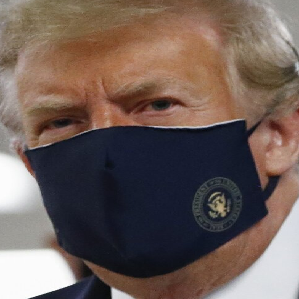

Image: dims.apnews.jpeg_face_1.png - Prediction: Mask (Probabilities: [9.9946982e-01 7.8321517e-07 5.2931276e-04])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


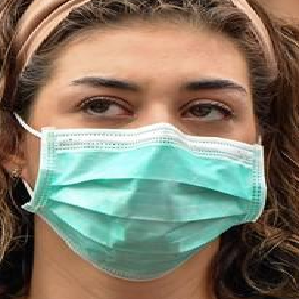

Image: mix_mask_3.jpg_face_1.png - Prediction: Mask (Probabilities: [9.4215375e-01 3.1309246e-06 5.7843164e-02])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


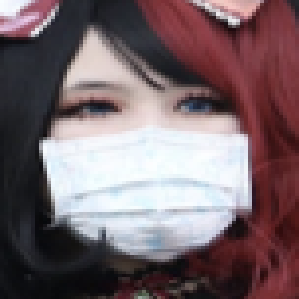

Image: w_mask_2.png_face_2.png - Prediction: Mask (Probabilities: [6.0949540e-01 2.0319011e-04 3.9030141e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


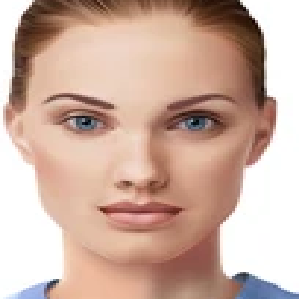

Image: test2.png_face_1.png - Prediction: Mask (Probabilities: [0.96249014 0.01812414 0.01938571])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


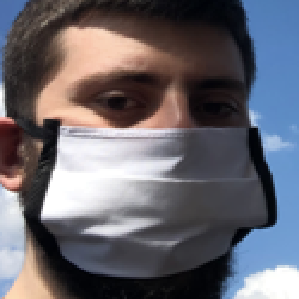

Image: w_mask_1.png_face_1.png - Prediction: Mask (Probabilities: [5.4580975e-01 1.1530578e-05 4.5417872e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


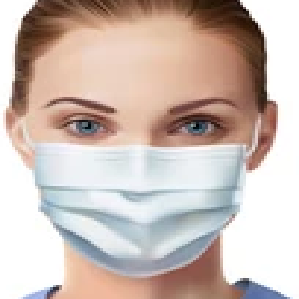

Image: test2.png_face_2.png - Prediction: Mask (Probabilities: [9.8417205e-01 2.0550124e-06 1.5825842e-02])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


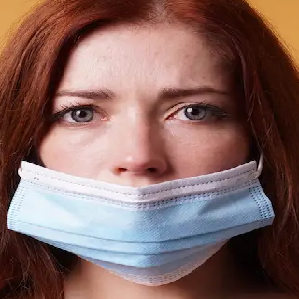

Image: girl_wrong_mask.jpg_face_1.png - Prediction: Wrong Mask (Probabilities: [8.1030473e-02 3.2869889e-06 9.1896623e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


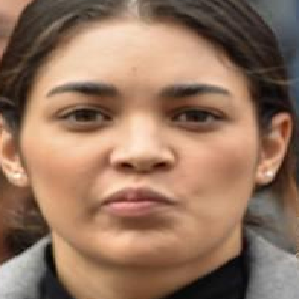

Image: mix_mask_3.jpg_face_2.png - Prediction: No Mask (Probabilities: [1.3658785e-06 9.9996746e-01 3.1172782e-05])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


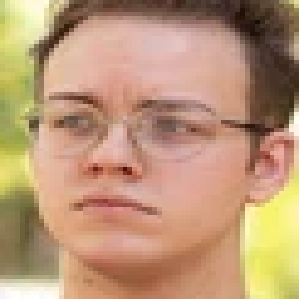

Image: test3.png_face_1.png - Prediction: Wrong Mask (Probabilities: [0.2903315  0.00525749 0.704411  ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


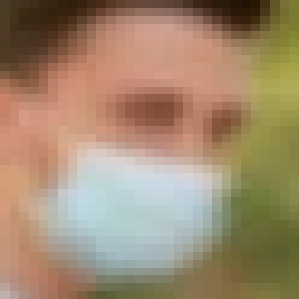

Image: test3.png_face_2.png - Prediction: Mask (Probabilities: [9.1383868e-01 6.9315650e-04 8.5468136e-02])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


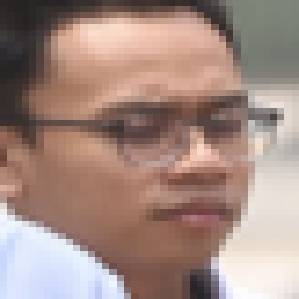

Image: mix_mask_2.png_face_2.png - Prediction: Mask (Probabilities: [7.5328815e-01 1.8681631e-04 2.4652502e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


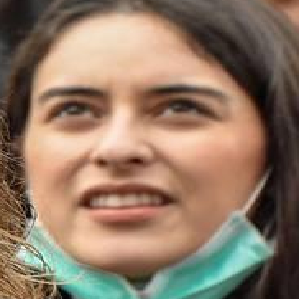

Image: mix_mask_3.jpg_face_3.png - Prediction: No Mask (Probabilities: [0.00649517 0.631157   0.3623478 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


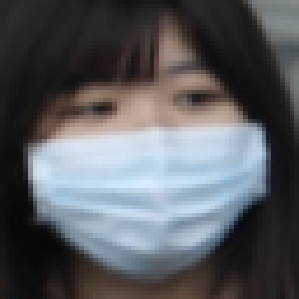

Image: w_mask_2.png_face_1.png - Prediction: Wrong Mask (Probabilities: [2.0624282e-02 1.2849222e-04 9.7924727e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


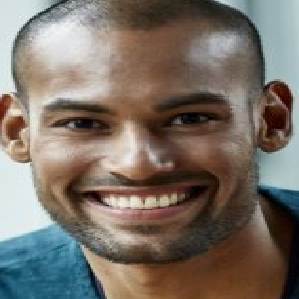

Image: test.jpg_face_1.png - Prediction: No Mask (Probabilities: [2.0237308e-04 9.8998368e-01 9.8138629e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


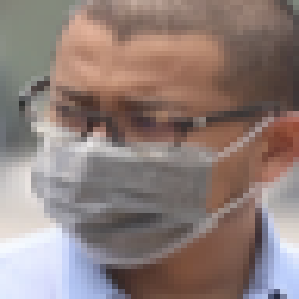

Image: mix_mask_2.png_face_1.png - Prediction: Wrong Mask (Probabilities: [3.3162493e-01 2.5699210e-05 6.6834944e-01])


In [9]:
# Folder containing images to test
test_images_folder = '../dataset/images/cropped'  # Update with your folder path

class_labels = ['Mask', 'No Mask', 'Wrong Mask']  # Update class labels accordingly

for image_name in os.listdir(test_images_folder):
    image_path = os.path.join(test_images_folder, image_name)
    # Load and preprocess the image
    img = load_img(image_path, target_size=(image_size, image_size))  # Resize to match input size
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Get class index with highest probability
    label = class_labels[predicted_class]  # Map index to class label
    
    display(img)
    print(f"Image: {image_name} - Prediction: {label} (Probabilities: {prediction[0]})")
